In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Scipy libraries
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Utils functions
from utils.utils import kfold, five_two, read_datasets, plot_pred_expected_results

# Load Dataset

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train_2.csv',
    'x_test_2.csv',
    'y_train_2.csv',
    'y_test_2.csv'
)

# Gradient Boosting regression - XGBoost

In [3]:
# The cross validation scheme to be used for train and test
folds = kfold()

## GridSearch

In [4]:
# hyper_params = {
#     'colsample_bytree': [0.1, 0.2, 0.3],
#     'n_estimators': [10, 20, 25, 50], #75, 100
#     'subsample': [0.5, 0.6, 0.7],
#     'max_depth': [1, 2, 3],
#     'booster': ['gbtree', 'dart'],
#     'objective': ["reg:squarederror"],
#     'eta': [0.1, 0.2, 0.3, 0.4, 0.9],
#     'gamma': [0, 0.3, 0.5],
#     'min_child_weight': [2, 3, 4],
#     'max_delta_step':[0, 1],
#     'reg_lambda': [0.3, 0.5, 0.7],
#     'alpha': [0.2, 0.3, 0.4],
#     'tree_method': ['approx', 'auto', 'exact', 'gpu_hist', 'hist'],
#     'max_leaves': [0, 1, 3, 5, 8],
#     'eval_metric': ['rmse'],
#     'base_score': [0.1, 0.3, 0.4, 0.5],
#     'grow_policy': ['depthwise'],
#     'refresh_leaf': [0,1],
#     'sampling_method': ['uniform'],
#     'colsample_bylevel': [0.1, 0.2, 0.5, 1],
#     'colsample_bynode': [0.1, 0.2, 0.5, 1],
#     'colsample_bytree': [0.1, 0.2, 0.4, 1],
#     'updater': ['grow_colmaker', 'grow_histmaker', 'grow_quantile_histmaker', 'grow_gpu_hist', 'sync', 'refresh', 'prune']
# }


hyper_params = {
    'colsample_bytree': [0.1, 0.2, 0.3],
    'n_estimators': [50],
    'subsample': [0.5],
    'max_depth': [1],
    'booster': ['gbtree'],
    'objective': ["reg:squarederror"],
    'eta': [0.3],
    'gamma': [0.5],
    'min_child_weight': [2],
    'max_delta_step':[0],
    'reg_lambda': [0.5],
    'alpha': [0.2],
    'tree_method': ['hist'],
    'max_leaves': [1],
    'eval_metric': ['rmse'],
    'base_score': [0.3],
    'grow_policy': ['depthwise'],
    'refresh_leaf': [1],
    'sampling_method': ['uniform'],
    'colsample_bylevel': [1],
    'colsample_bynode': [0.5],
    'colsample_bytree': [1],
    'updater': ['grow_colmaker']
}



# Call RandomizedSearchCV()
model_cv = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(),
    param_distributions = hyper_params,
    n_iter=15000,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[06:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
{'updater': 'grow_colmaker', 'tree_method': 'hist', 'subsample': 0.5, 'sampling_method': 'uniform', 'reg_lambda': 0.5, 'refresh_leaf': 1, 'objective': 'reg:squarederror', 'n_estimators': 50, 'min_child_weight': 2, 'max_leaves': 1, 'max_depth': 1, 'max_delta_step': 0, 'grow_policy': 'depthwise', 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.3, 'colsample_bytree': 1, 'colsample_bynode': 0.5, 'colsample_bylevel': 1, 'booster': 'gbtree', 'base_score': 0.3, 'alpha': 0.2}


In [5]:
# Create new model with best_params_ from grid search

xgboost_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Validation Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.40672630499440887, 0.3991088883606113, 0.39655167635397837, 0.3887413850487118, 0.42637176535988264, 0.4418187969054753, 0.39325037181471845, 0.4161004632461909, 0.4145566521275271, 0.415131986998698]
Validation Results: [0.19174189029758948, 0.2958880679478769, 0.21174812919368313, 0.25973055256250743, 0.22764665355642488, -0.1400320560267978, 0.26704520249596575, 0.23223104815602602, 0.08495952735694245, 0.29838219577809333]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.40983582912102035
Train std: 0.015515110674216393
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.19293412113183117
Validation std: 0.12542033805229114


In [8]:
y_pred = xgboost_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1347


In [11]:
res_df = pd.DataFrame()
res_df['Esperado'] = y_test
res_df['Predito'] = y_pred
res_df['Residuo'] = res_df['Esperado'] - res_df['Predito']

res_df.head()

,Esperado,Predito,Residuo
0,73,73.369385,-0.369385
1,38,66.658546,-28.658546
2,14,47.686352,-33.686352
3,10,43.047512,-33.047512
4,91,62.817902,28.182098


In [14]:
(res_df['Residuo'] > 0).sum().sum()

38

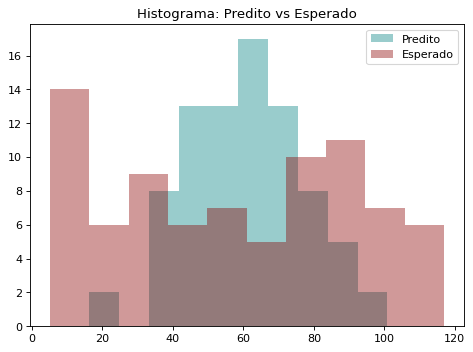

In [13]:
from matplotlib.pyplot import figure
figure(figsize=(7, 5), dpi=80)

plt.hist(y_pred, label='Predito', color='teal', alpha=0.4)
plt.hist(y_test, label='Esperado', color='darkred', alpha=0.4)
plt.title('Histograma: Predito vs Esperado')
plt.legend()
plt.show()

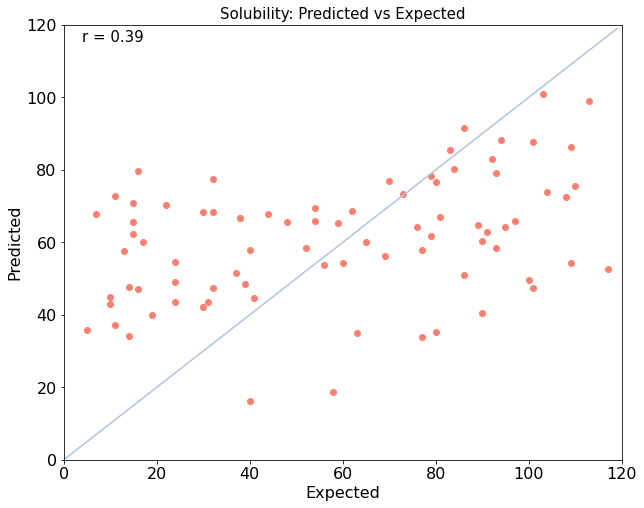

In [9]:
# Plot the R2 predicted and expected results

plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/xgboost_model_high_removed.joblib'
joblib.dump(xgboost_best, filename)

['../models/xgboost_model_high_removed.joblib']

## Notes

* Create 10 folds
* Set grid for the RandomSearchCV
* Search and fit the model with best params
* Get the results (r2) for each train and test results for training data
* Get the result (r2) for test data